In [1]:
import pydicom
from glob import glob
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import os
import shutil
import SimpleITK as sitk
import time
from natsort import natsorted
from matplotlib import pyplot as plt
from collections import Counter
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
import SimpleITK as sitk
from collections import Counter
import pydicom
from datetime import datetime

def byte_string_to_list(byte_string):
    # 바이트 문자열을 문자열로 디코딩
    decoded_string = byte_string.decode('utf-8')
    decoded_string = decoded_string.split('\\')
    # "\\"을 기준으로 문자열을 분리하여 리스트 생성
    return [float(item) for item in decoded_string]

def get_image_position(dcm_obj):
    encoded_image_position = dcm_obj.get_item(pydicom.tag.Tag((0x0020, 0x0032))).value
    return byte_string_to_list(encoded_image_position)

def group_dicom_series_by_uid(target_dcm_path_list, exclude_first_dicom=False):
    total_dcm_path_list = deepcopy(target_dcm_path_list)
    total_dcm_path_list = natsorted(total_dcm_path_list)
    series_dict = {}
    
    for filepath in tqdm(total_dcm_path_list):  # 리스트가 비워질 때까지 반복
        # DICOM 파일 로드
        ds = pydicom.dcmread(filepath, force=True, stop_before_pixels=True)
        
        # SeriesInstanceUID를 사용하여 시리즈 구분
        try:
            series_uid = ds.SeriesInstanceUID
        except:
            series_uid = None
        
        # 해당 시리즈 UID의 리스트에 파일 추가 (없다면 새로 생성)
        if series_uid not in series_dict:
            series_dict[series_uid] = []
        series_dict[series_uid].append(filepath)
    
    for key, value in series_dict.items():
        if exclude_first_dicom:
            series_dict[key] = natsorted(value)[1:]
        else:
            series_dict[key] = natsorted(value)
    return series_dict

def get_orientation(dcm_path):
    image_orientation = pydicom.dcmread(dcm_path, force=True).ImageOrientationPatient
    image_orientation = [round(float(item), 1) for item in image_orientation]
    return image_orientation

def check_is_axial(target_dcm_path_list):
    target_dcm_path_list = natsorted(target_dcm_path_list)
    axial_orientation = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0)
    try:
        orientation_list = [tuple(get_orientation(dcm_path))
                            for dcm_path in target_dcm_path_list]
    except AttributeError:
        return False, [(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)], []
    
    orientation_counter = Counter(orientation_list)
    most_common_orientation, most_common_value = orientation_counter.most_common(1)[0]
    is_axial = most_common_orientation == axial_orientation 
    is_in_list = [orientation == most_common_orientation for orientation in orientation_list]
    return is_axial, most_common_orientation, is_in_list

def get_parent_dir_name(path, level=1):
    path_spliter = os.path.sep
    abs_path = os.path.abspath(path)

    return abs_path.split(path_spliter)[-(1 + level)]

def get_slice_thickness(current_dcm_path_list):
    dcm_obj = pydicom.dcmread(current_dcm_path_list[0], force=True)
    return dcm_obj["SliceThickness"].value

def dicom_to_png(dicom_file_path, output_path):
    # DICOM 파일 읽기
    reader = sitk.ImageFileReader()
    reader.SetFileName(dicom_file_path)
    image = reader.Execute()
    
    # Pixel data 추출
    data = sitk.GetArrayFromImage(image)[0]
    
    # 기본 정규화 (windowing 정보가 없는 경우)
    data = ((data - np.min(data)) / (np.max(data) - np.min(data)) * 255).astype(np.uint8)
    
    # Grayscale 이미지로 변환
    if image.GetMetaData("0028|0004") == "MONOCHROME1":
        data = np.amax(data) - data
    
    # 이미지 저장
    img = Image.fromarray(data)
    img.save(output_path)

def get_attr(dicom_file_path, find_attr_name):
    try:
        dcm = pydicom.dcmread(dicom_file_path, force=True)
        attr_name = getattr(dcm, find_attr_name, None)
        if find_attr_name == "PatientAge":
            attr_name = attr_name[1] + "0"
        if find_attr_name == "StudyDate":
            attr_name = attr_name[:4]
        return attr_name
    except Exception as e:
        print(f"Error reading DICOM file {dicom_file_path}: {e}")
        return None
    
def change_item(item):
    
    item = item if item is not None else 0
    item = float(item) * 2
    item = round(item) / 2
    return item

def find_dicom_files(data_path):
    dicom_files = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            data_path = os.path.join(root, file)
            if os.path.isfile(data_path):
                if '.xls' in data_path:
                    continue
                else:
                    try:
                        pydicom.dcmread(data_path, force=True)
                        is_readable_dcm = True
                    except:
                        is_readable_dcm = False
                    if is_readable_dcm:
                        dicom_files.append(data_path)
                    else:
                        continue
            else:
                continue
    return dicom_files

def check_dicom_size(filepath):
    try:
        # DICOM 파일 읽기
        dicom_data = pydicom.dcmread(filepath)
        # Rows와 Columns 값 가져오기
        rows = dicom_data.Rows
        cols = dicom_data.Columns
        
        # Rows와 Columns가 512인지 확인
        is_512 = rows == 512 and cols == 512
        dicom_shape = (rows, cols)
    except Exception as e:
        is_512 = False
        dicom_shape = (0, 0)
    return is_512, dicom_shape

def get_parent_dir_name(path, level=1):

    path_spliter = os.path.sep
    abs_path = os.path.abspath(path)

    return abs_path.split(path_spliter)[-(1 + level)]

def get_attr(dicom_file_path, find_attr_name):
    try:
        dcm = pydicom.dcmread(dicom_file_path, force=True)
        attr_name = getattr(dcm, find_attr_name, None)
        if find_attr_name == "PatientAge":
            attr_name = attr_name[1] + "0"
        if find_attr_name == "StudyDate":
            attr_name = attr_name[:4]
        return attr_name
    except Exception as e:
        print(f"Error reading DICOM file {dicom_file_path}: {e}")
        return None

def plot_bar(attribute_list, attr_name):    
    kernel_counter = Counter(attribute_list)

    plt.figure(figsize=(14, 6))
    bars = plt.bar(kernel_counter.keys(), kernel_counter.values(), color='skyblue')

    plt.xlabel(attr_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of DICOM {attr_name}')
    plt.xticks(rotation=0, fontsize=8)
    # Add frequency labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    
def save_ct_series_as_dicom(ct_image, dcm_path_list, patient_name="Anonymous", study_id="CT Study"):
    """
    3D SimpleITK CT 이미지를 DICOM 시리즈로 저장.

    Args:
        ct_image (sitk.Image): SimpleITK 3D CT 이미지.
        output_dir (str): 저장할 디렉토리.
        patient_name (str): 환자 이름. 기본값은 "Anonymous".
        study_id (str): 스터디 ID. 기본값은 "CT Study".
    """
    # CT 이미지 메타데이터
    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()
    
    # 슬라이스 저장
    ct_depth = ct_image.GetDepth()
    ct_depth_range = range(ct_depth)
    for i, dcm_path in zip(ct_depth_range, dcm_path_list):
        slice_image = ct_image[:, :, i]
        # 슬라이스 위치 메타데이터
        slice_image.SetMetaData("0020|0013", str(i + 1))  # Instance Number
        
        writer.SetFileName(dcm_path)
        writer.Execute(slice_image)

In [2]:
data_path = "../data/3_external_data/0_source_data/"
assert os.path.exists(data_path)
dcm_path_list = find_dicom_files(data_path)

In [3]:
#selected and group axial series
splited_dcm_path_dict = group_dicom_series_by_uid(dcm_path_list)

100%|██████████████████████████████████████████████████████████████████████████████| 8277/8277 [00:44<00:00, 185.93it/s]


In [4]:
axial_key_list = []
orientation_list = []
is_in_total_list = []
for key, items in tqdm(splited_dcm_path_dict.items()):
    items = sorted(items)
    
    if len(items) > 10: 
        is_axial, most_common_orientation, is_in_list = check_is_axial(items)
        orientation_list.append(most_common_orientation)
        if is_axial:
            axial_key_list.append(key)
            is_in_total_list.append(is_in_list)

selected_dcm_path_dict = {axial_key: [dcm_path for dcm_path, is_in in zip(splited_dcm_path_dict[axial_key], is_in_list) if is_in] 
                          for axial_key, is_in_list in zip(axial_key_list, is_in_total_list)}

add_series_id_list = ['1.3.12.2.1107.5.1.4.73271.30000024080823432033900024296']
for add_series_id in add_series_id_list:
    dcm_path_list = splited_dcm_path_dict[add_series_id]
    is_in_list = check_is_axial(dcm_path_list)[-1]
    dcm_path_list = [dcm_path for dcm_path, is_in in zip(dcm_path_list, is_in_list) if is_in]
    selected_dcm_path_dict[add_series_id] = dcm_path_list
    

print(f"Selected Dcm Series Num: {len(selected_dcm_path_dict)}")

100%|█████████████████████████████████████████████████████████████████████████████████| 190/190 [00:39<00:00,  4.82it/s]


Selected Dcm Series Num: 23


In [7]:
selected_data_folder = "../data/4_external_data_selected"
if not os.path.exists(selected_data_folder):
    os.makedirs(selected_data_folder)
    print(f"Directory '{selected_data_folder}' created.")
else:
    print(f"Directory '{selected_data_folder}' already exists.")

Directory '../data/4_external_data_selected' already exists.


In [6]:
from utils import get_z_position, resize_dicom_series, write_series_to_path

def add_ext_dcm(target_path):
    if target_path[-4:] != ".dcm":
        target_path = f"{target_path}.dcm"
    return target_path

target_hw = (512, 512)
for index, (series_uid, current_dcm_path_list) in tqdm(enumerate(selected_dcm_path_dict.items())):
    mod_3 = len(current_dcm_path_list) % 3
    if mod_3 != 0:
        current_dcm_path_list = current_dcm_path_list[:-mod_3]
    
    original_sample_path = current_dcm_path_list[0]
    folder_basename = get_parent_dir_name(original_sample_path, level=2)
    current_thickness = float(get_slice_thickness(current_dcm_path_list))
    
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(current_dcm_path_list)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    
    image = reader.Execute()
    image_size = image.GetSize()
    resize_factor_hw = target_hw / np.array(image_size)[:2]
    resize_factor_list = (*resize_factor_hw, 1)
    
    image_sample = image[:, :, 0]
    dicom_file = pydicom.dcmread(current_dcm_path_list[0], force=True)
    dicom_file_next = pydicom.dcmread(current_dcm_path_list[1], force=True)
    image_position_z_diff = np.abs(get_z_position(dicom_file_next) - get_z_position(dicom_file))
    original_z_spacing = image_position_z_diff
    slice_num = len(current_dcm_path_list)
    target_path = f"{selected_data_folder}/{series_uid}/{current_thickness:.3f}"
    
    resized_image = resize_dicom_series(image, resize_factor_list, is_label=False, resize_method="sitk")
    resized_image_size = resized_image.GetSize()
    print(f"sample path: {index} {original_sample_path}")
    print("Image size:", *image_size, "=> resample size:", *resized_image_size)
    print("resize image:", resized_image_size[0], resized_image_size[1], resized_image_size[2])
    print(f"slice_thickness: {current_thickness} => {current_thickness}")
    print(f"image_direction: {resized_image.GetDirection()}")
    print(f"target_path: {target_path}")
    
    write_series_to_path(reader=reader,
                     target_image=resized_image, 
                     original_sample_path=original_sample_path, 
                     target_path=target_path, 
                     slice_thickness=current_thickness,
                     inverse_instance_num=False)

0it [00:00, ?it/s]

sample path: 0 ../data/3_external_data/0_source_data/20240524/CT/00000026/00007998
Image size: 512 512 63 => resample size: 512 512 63
resize image: 512 512 63
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249500962833/2.000


1it [00:05,  5.77s/it]

sample path: 1 ../data/3_external_data/0_source_data/20240528/CT/00000025/00007639
Image size: 512 512 96 => resample size: 512 512 96
resize image: 512 512 96
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249500992821/2.000


2it [00:13,  7.20s/it]

sample path: 2 ../data/3_external_data/0_source_data/20240604/CT/00000024/00007293
Image size: 512 512 96 => resample size: 512 512 96
resize image: 512 512 96
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249501049378/2.000


3it [00:22,  7.72s/it]

sample path: 3 ../data/3_external_data/0_source_data/20240613/CT/00000023/00006934
Image size: 512 512 72 => resample size: 512 512 72
resize image: 512 512 72
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249501104125/2.000


4it [00:29,  7.34s/it]

sample path: 4 ../data/3_external_data/0_source_data/20240702/CT/00000022/00006604
Image size: 512 512 105 => resample size: 512 512 105
resize image: 512 512 105
slice_thickness: 2.0 => 2.0
image_direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.1.4.73271.30000024070120571734000018233/2.000


5it [00:38,  7.99s/it]

sample path: 5 ../data/3_external_data/0_source_data/20240712/CT/00000021/00006326
Image size: 512 512 69 => resample size: 512 512 69
resize image: 512 512 69
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249501340866/2.000


6it [00:44,  7.29s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkImageSeriesReader.hxx, line 478
ImageSeriesReader (0x40a93ca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000925275



sample path: 6 ../data/3_external_data/0_source_data/20240719/CT/00000020/00006024
Image size: 559 512 57 => resample size: 512 512 57
resize image: 512 512 57
slice_thickness: 3.0 => 3.0
image_direction: (0.9991832240113276, 0.023967456170989925, 0.0325337655216988, -0.024570341390625285, 0.9995313351355368, 0.018259474420681838, -0.032080884936007095, -0.019043926245999942, 0.9993038305214584)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.1.4.73271.30000024071904171261200011263/3.000


7it [00:49,  6.57s/it]

sample path: 7 ../data/3_external_data/0_source_data/20240822/CT/00000018/00005173
Image size: 512 512 96 => resample size: 512 512 96
resize image: 512 512 96
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249501545825/2.000


8it [00:57,  7.15s/it]

sample path: 8 ../data/3_external_data/0_source_data/20240830/CT/00000017/00004764
Image size: 512 512 81 => resample size: 512 512 81
resize image: 512 512 81
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000023120705151249501591320/2.000


9it [01:04,  7.10s/it]

sample path: 9 ../data/3_external_data/0_source_data/20240905/CT/00000016/00004519
Image size: 512 512 84 => resample size: 512 512 84
resize image: 512 512 84
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024090300052076500017843/2.000


10it [01:11,  7.14s/it]

sample path: 10 ../data/3_external_data/0_source_data/20240920/CT/00000015/00003977
Image size: 512 512 87 => resample size: 512 512 87
resize image: 512 512 87
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024090300052076500091038/2.000


11it [01:19,  7.26s/it]

sample path: 11 ../data/3_external_data/0_source_data/20240927/CT/00000014/00003528
Image size: 512 512 81 => resample size: 512 512 81
resize image: 512 512 81
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024090300052076500125625/2.000


12it [01:26,  7.28s/it]

sample path: 12 ../data/3_external_data/0_source_data/20241004/CT/00000013/00003194
Image size: 512 512 90 => resample size: 512 512 90
resize image: 512 512 90
slice_thickness: 2.0 => 2.0
image_direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.1.4.73271.30000024100321020516500044029/2.000


13it [01:34,  7.49s/it]

sample path: 13 ../data/3_external_data/0_source_data/20241011/CT/00000012/00002831
Image size: 512 512 66 => resample size: 512 512 66
resize image: 512 512 66
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900080188/2.000


14it [01:40,  7.03s/it]

sample path: 14 ../data/3_external_data/0_source_data/20241024/CT/00000011/00002468
Image size: 512 512 51 => resample size: 512 512 51
resize image: 512 512 51
slice_thickness: 0.75 => 0.75
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900151118/0.750


15it [01:45,  6.31s/it]

sample path: 15 ../data/3_external_data/0_source_data/20241025/CT/00000010/00002126
Image size: 512 512 45 => resample size: 512 512 45
resize image: 512 512 45
slice_thickness: 0.75 => 0.75
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900163688/0.750


16it [01:49,  5.64s/it]

sample path: 16 ../data/3_external_data/0_source_data/20241031/CT/00000009/00001777
Image size: 512 512 54 => resample size: 512 512 54
resize image: 512 512 54
slice_thickness: 0.75 => 0.75
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900197118/0.750


17it [01:54,  5.42s/it]

sample path: 17 ../data/3_external_data/0_source_data/20241105/CT/00000008/00001519
Image size: 512 512 60 => resample size: 512 512 60
resize image: 512 512 60
slice_thickness: 0.75 => 0.75
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900225172/0.750


18it [01:59,  5.47s/it]

sample path: 18 ../data/3_external_data/0_source_data/20241112/CT/00000004/00000013
Image size: 512 512 87 => resample size: 512 512 87
resize image: 512 512 87
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900286776/2.000


19it [02:07,  6.16s/it]

sample path: 19 ../data/3_external_data/0_source_data/20241112/CT/00000005/00000421
Image size: 512 512 90 => resample size: 512 512 90
resize image: 512 512 90
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900285679/2.000


20it [02:15,  6.75s/it]

sample path: 20 ../data/3_external_data/0_source_data/20241112/CT/00000006/00000824
Image size: 512 512 87 => resample size: 512 512 87
resize image: 512 512 87
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900281082/2.000


21it [02:23,  7.08s/it]

sample path: 21 ../data/3_external_data/0_source_data/20241112/CT/00000007/00001201
Image size: 512 512 72 => resample size: 512 512 72
resize image: 512 512 72
slice_thickness: 2.0 => 2.0
image_direction: (1.0, -1.2246468e-16, 0.0, 1.2246468e-16, 1.0, 0.0, 0.0, 0.0, 1.0)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.99.2.46822.30000024093000304744900279391/2.000


22it [02:29,  6.86s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkImageSeriesReader.hxx, line 478
ImageSeriesReader (0x40b83f90): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00120233



sample path: 22 ../data/3_external_data/0_source_data/20240809/CT/00000019/00005666
Image size: 584 512 81 => resample size: 512 512 81
resize image: 512 512 81
slice_thickness: 2.0 => 2.0
image_direction: (0.8991092437212885, -0.07008513514600005, -0.43207712469708437, -1.149011441547999e-13, 0.9870987720107907, -0.16011250511683725, 0.43772430576212346, 0.14395863338597015, 0.8875096303808263)
target_path: ../data/4_external_data_selected/1.3.12.2.1107.5.1.4.73271.30000024080823432033900024296/2.000


23it [02:36,  6.81s/it]


# Data EDA (plot attr bar)

In [45]:
series_thickness_list = []
slice_thickness_list = []
for key, dcm_path_list in tqdm(selected_dcm_path_dict.items()):
    series_thickness = []
    for idx, dcm_path in enumerate(dcm_path_list):
        dcm_obj = pydicom.dcmread(dcm_path, force=True, stop_before_pixels=True)
        if "SliceThickness" in dcm_obj:
            slice_thickness = dcm_obj["SliceThickness"].value
        
        else:
            slice_thickness = None
        series_thickness.append(round(slice_thickness, 2))
        slice_thickness_list.append(round(slice_thickness, 2))
    series_thickness = set(series_thickness)
    if len(series_thickness) == 1:
        series_thickness_list.append(list(series_thickness)[0])
    else:
        raise
series_unique_count = Counter(series_thickness_list)
slice_unique_count = Counter(slice_thickness_list)
print(series_unique_count)
print(slice_unique_count)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:17<00:00,  1.27it/s]

Counter({2.0: 17, 0.75: 4, 3.0: 1})
Counter({2.0: 374, 0.75: 88, 3.0: 22})


In [46]:
#plot histogram
attr_list = []
for key, dcm_path_list in tqdm(selected_dcm_path_dict.items()):
    for idx, dcm_path in enumerate(dcm_path_list):
        dcm_obj = pydicom.dcmread(dcm_path, force=True, stop_before_pixels=True)
        if "InstitutionName" in dcm_obj:
            institution_name = dcm_obj["InstitutionName"].value
        else:
            institution_name = None
        attr_list.append(institution_name)
        break
attr_unique_count = Counter(attr_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 77.55it/s]


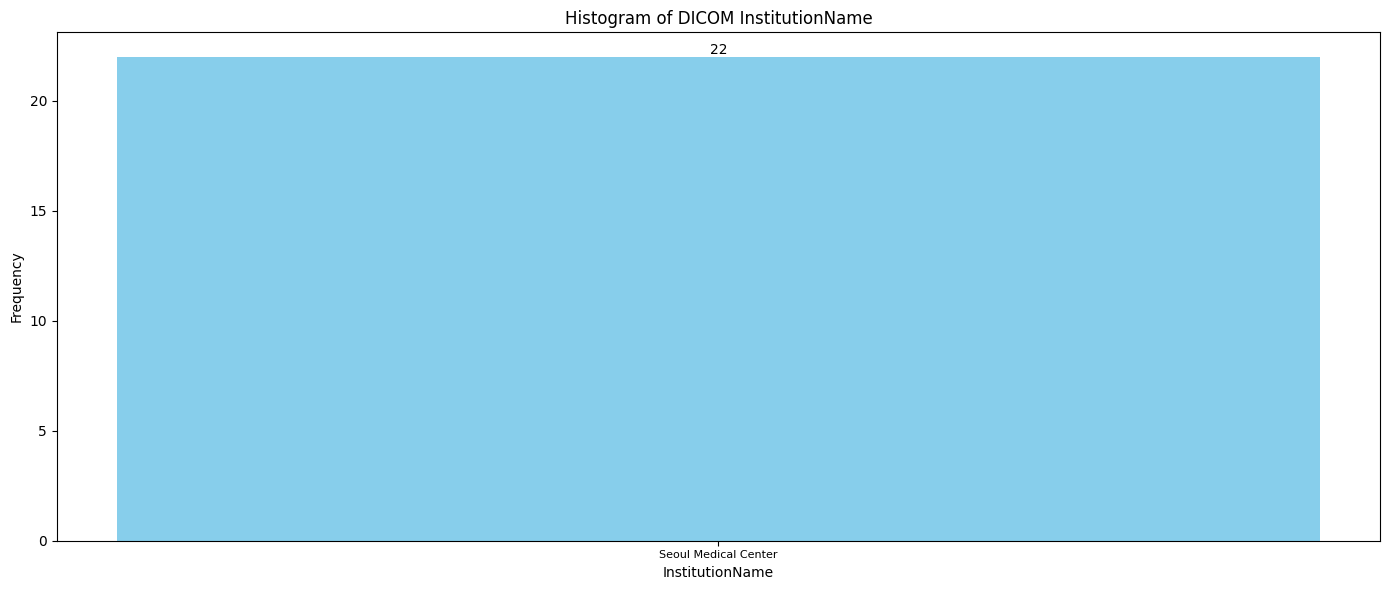

In [47]:
plot_bar(attr_unique_count, "InstitutionName")



In [111]:
def get_two_dcm_path(directory):
    dcm_path_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file[-4:] == ".dcm":
                dcm_path_list.append(file_path)
                if len(dcm_path_list) ==2:
                    return dcm_path_list

def get_attr(dicom_file_path, find_attr_name):
    try:
        dcm = pydicom.dcmread(dicom_file_path, force=True)
        attr_name = getattr(dcm, find_attr_name, None)
        if find_attr_name == "PatientAge":
            attr_name = attr_name[1]+"0"
        if find_attr_name == "StudyDate":
            attr_name = attr_name[:4]
        return attr_name
    except Exception as e:
        print(f"Error reading DICOM file {dicom_file_path}: {e}")
        return None
    
def change_item(item):
    item = item if item is not None else 0
    item = float(item)*2
    item = round(item)/2
    return item

def plot_bar(targets, attr_name):
    kernel_counter = Counter(targets)
    
    plt.figure(figsize=(14,6))
    bars = plt.bar(kernel_counter.keys(), kernel_counter.values(), color='skyblue')
    plt.xlabel(attr_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of DICOM {attr_name}')
    plt.xticks(rotation=0,fontsize=8)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x()+ bar.get_width()/2, height, str(height), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
folder_list = glob(f"{selected_data_folder}/*/*")
print(len(folder_list))

22


In [61]:
dicom_keys = {
    "InstitutionName": ("0008", "0080"),
    "PatientAge": ("0010", "1010"),
    "PatientSex": ("0010", "0040"),
    "StudyDate": ("0008", "0020"), # You may also want to check AcquisitionDate ("0008", "0022") and ContentDate ("0008", "0023")
    "Manufacturer": ("0008", "1090"),
    "ConvolutionKernel": ("0018", "1210"),
    "SliceThickness": ("0018", "0050"),
    "SpacingBetweenSlices": ("0018", "0088")
}

In [63]:
first_dicom_path_list = [get_two_dcm_path(folder)[0] for folder in folder_list]
os.makedirs("./visualize", exist_ok=True)
for dicom_path in first_dicom_path_list:
    dicom_basename = os.path.basename(dicom_path)
    png_basename = dicom_basename.replace(".dcm", ".png")
    dicom_to_png(dicom_path, f"./visualize/{png_basename}")
    
                         

/tmp/ipykernel_20264/2025826810.py:101: RuntimeWarning: overflow encountered in scalar subtract
  data = ((data - np.min(data)) / (np.max(data) - np.min(data)) * 255).astype(np.uint8)


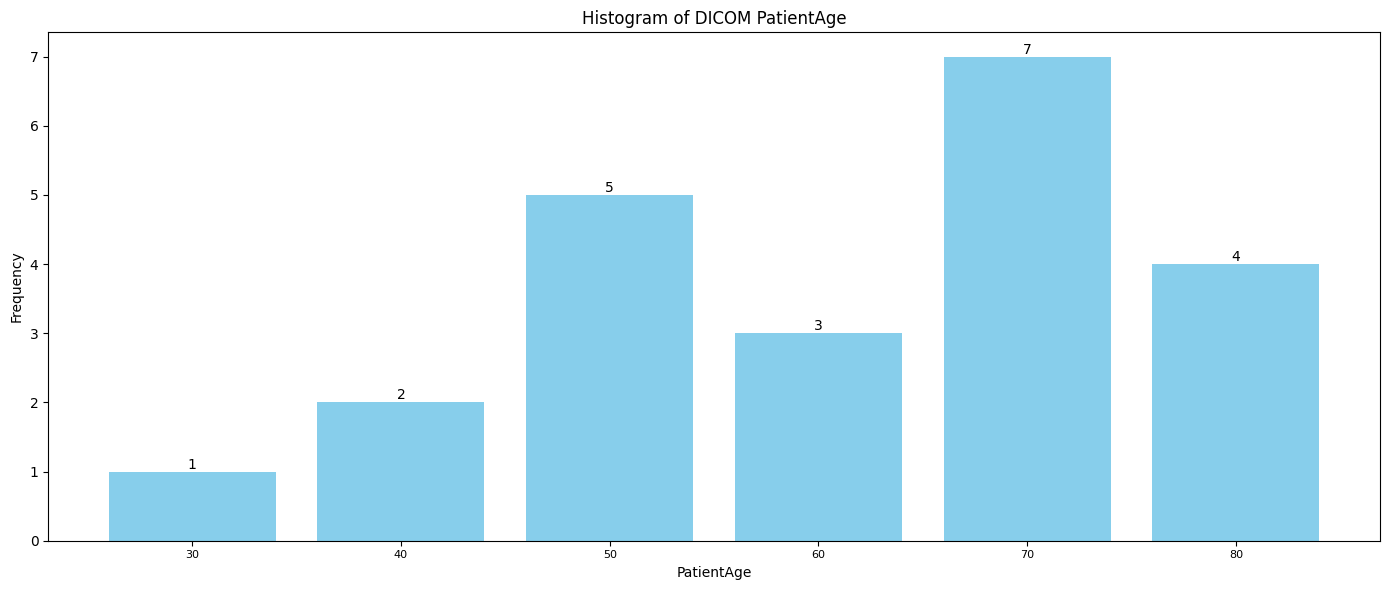

In [114]:
def sort_by_age(attribute_list):
    return sorted(attribute_list)

attribute_name = "PatientAge"

attribute_list = [get_attr(dicom_path, attribute_name) for dicom_path in first_dicom_path_list]
# attribute_list = [change_item(item) for item in attribute_list]
# 나이순으로 정렬
sorted_attribute_list = sort_by_age(attribute_list)

# 정렬된 리스트를 plot_bar 함수에 전달
plot_bar(sorted_attribute_list, attribute_name)

In [121]:
os.makedirs("./temp", exists_ok=True)
for dcm_path in (selected_dcm_path_dict["1.3.12.2.1107.5.99.2.46822.30000024093000304744900225172"]):
    shutil.copy(dcm_path, f"./temp/{os.path.basename(dcm_path)}")


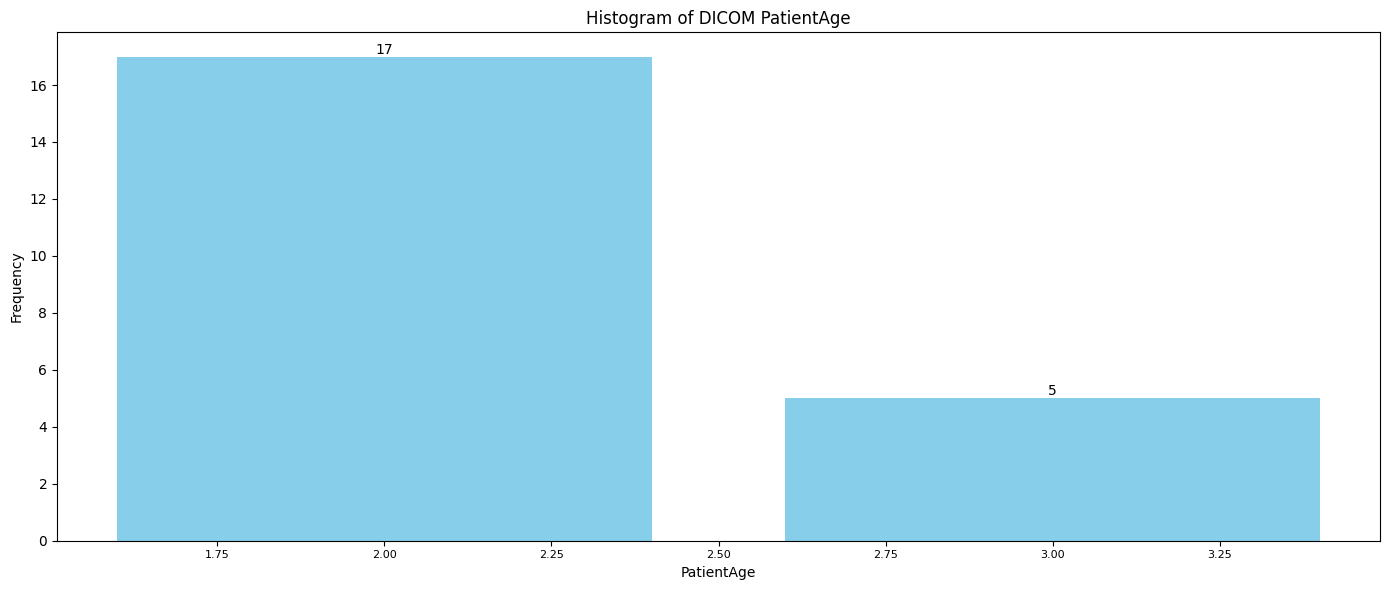

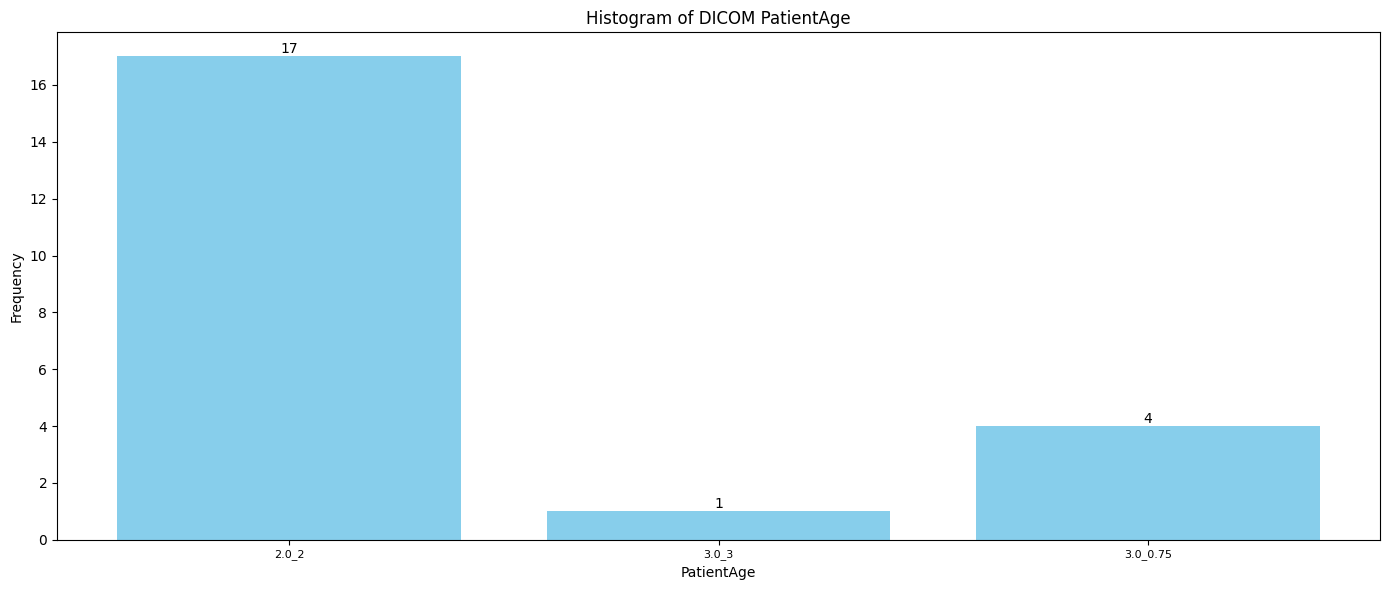

In [115]:
def get_slice_location(dcm_path):
    dcm_obj = pydicom.dcmread(dcm_path, force=True)
    image_postion_list = dcm_obj["ImagePositionPatient"].value
    slice_location = float(image_postion_list[-1])
    return slice_location

def compute_slice_interval(folder_list):
    dicom_pair_list = [get_two_dcm_path(folder) for folder in folder_list]
    image_location_list = [[get_slice_location(dcm_path) for dcm_path in dcm_pair] for dcm_pair in dicom_pair_list]
    slice_interval_list = [round(np.abs(item[0] - item[1]), 1) for item in image_location_list]
    return slice_interval_list

attribute_list = compute_slice_interval(folder_list)
plot_bar(attribute_list, attribute_name)

interval_list = compute_slice_interval(folder_list)
thickness_list = [get_attr(dicom_path, "SliceThickness") for dicom_path in first_dicom_path_list]
attribute_list = [f"{interval}_{thickness}" for interval, thickness in zip(interval_list, thickness_list)]
plot_bar(attribute_list, attribute_name)

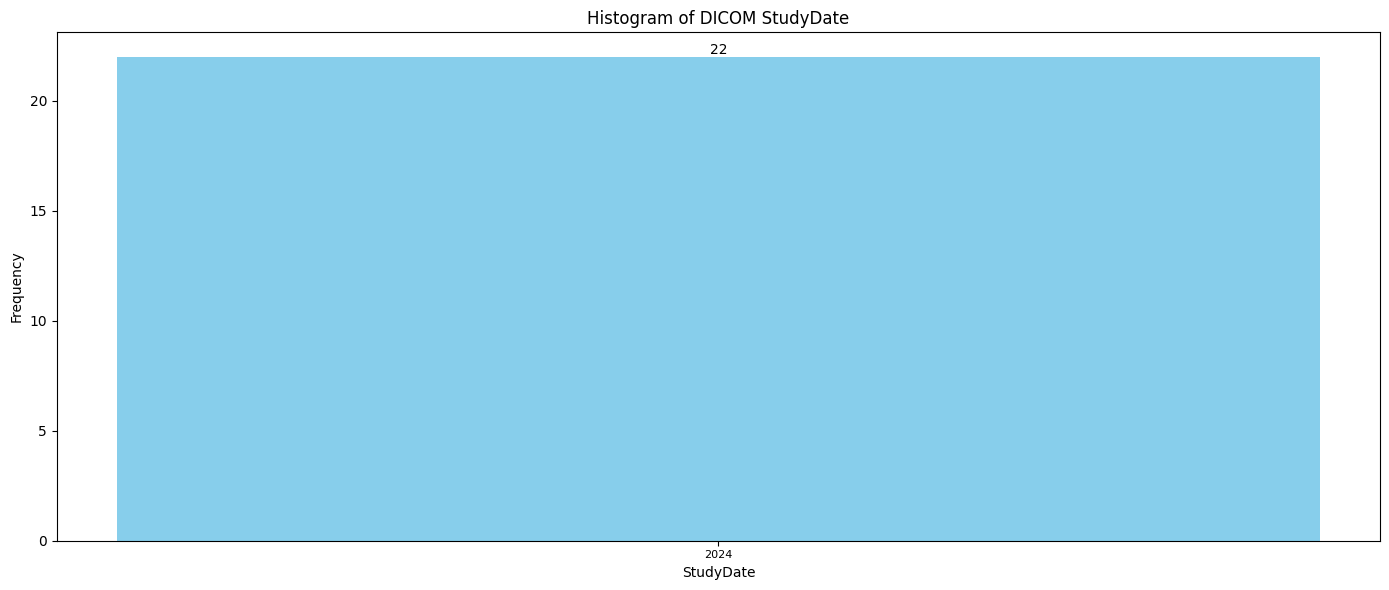

In [112]:
attribute_name = "StudyDate"
attribute_list = [get_attr(dicom_path, attribute_name) for dicom_path in first_dicom_path_list]
# attribute_list = [change_item(item) for item in attribute_list]
plot_bar(attribute_list, attribute_name)

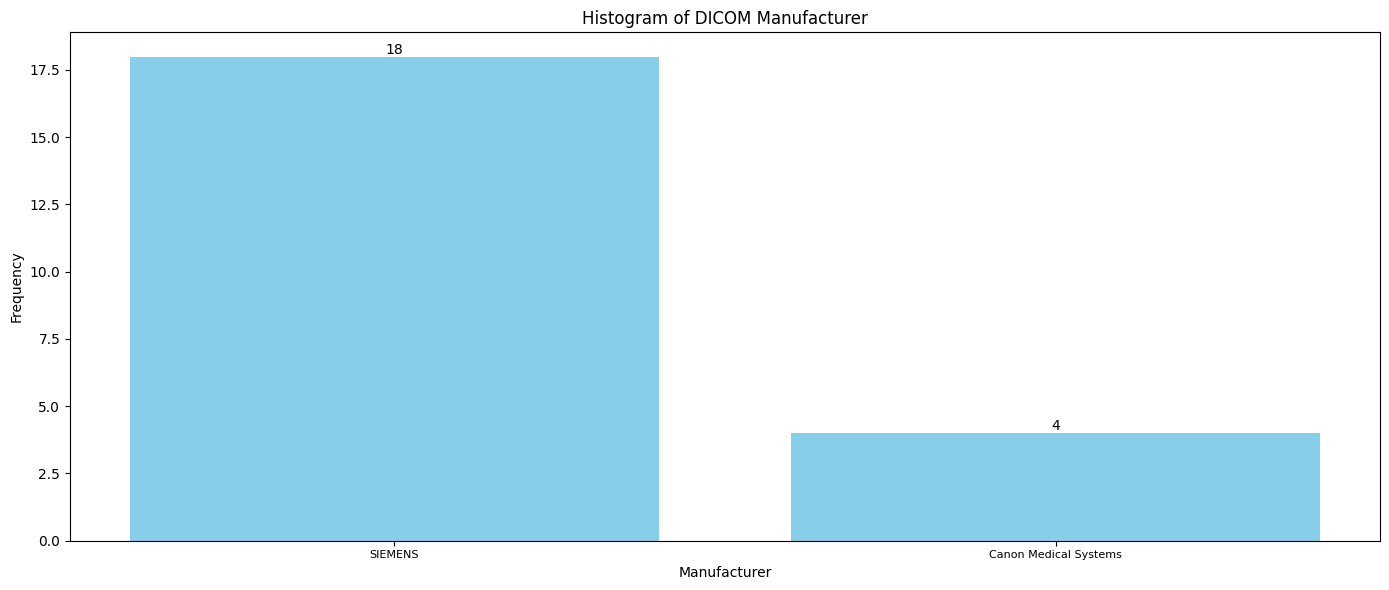

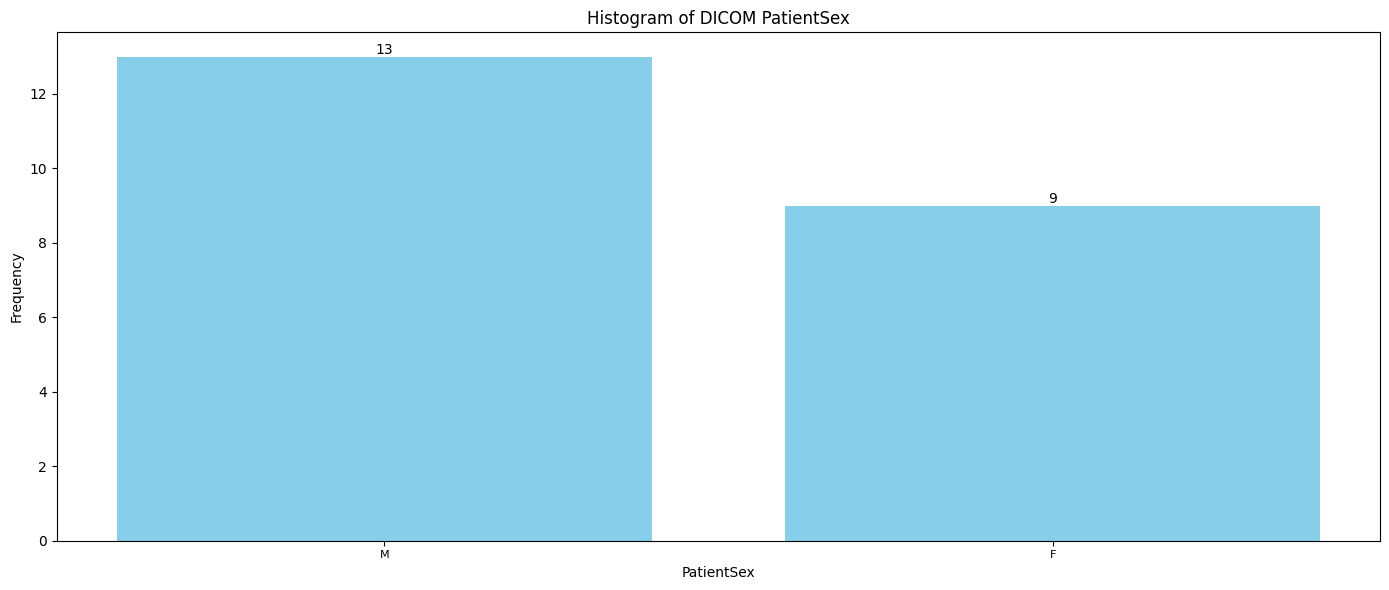

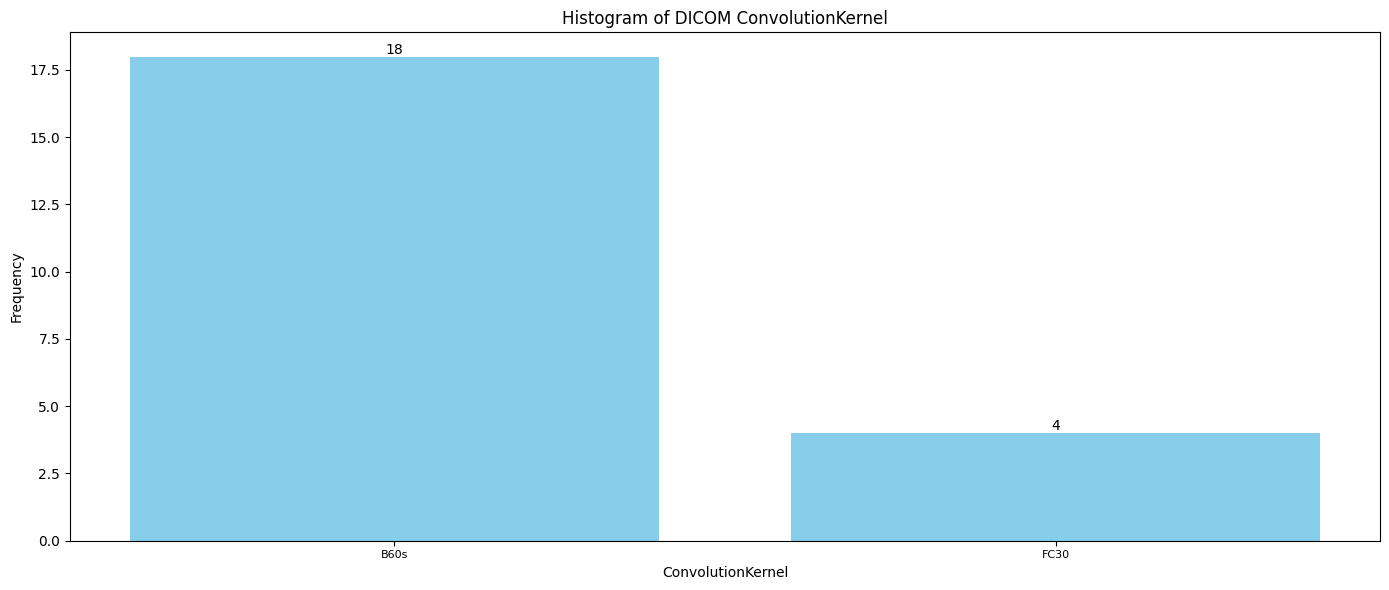

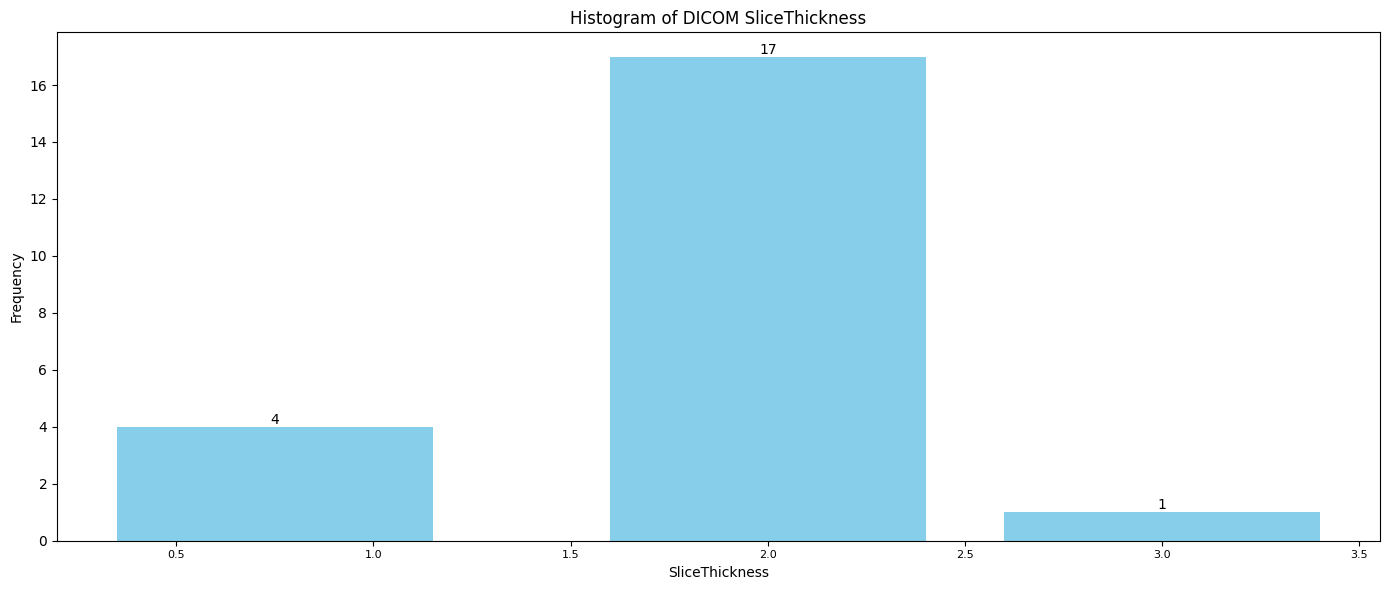

In [98]:
check_attr_list = ["Manufacturer", "PatientSex", "ConvolutionKernel", "SliceThickness"]

for attribute_name in check_attr_list:
    attribute_list = [get_attr(dicom_path, attribute_name) for dicom_path in first_dicom_path_list]
    # attribute_list = [change_item(item) for item in attribute_list]
    plot_bar(attribute_list, attribute_name)


# Unused Code

In [ ]:
def resample_with_orientation_crop_and_pad(image, image_orientation_patient, crop_background=True, 
                                           empty_space_value=0, min_size=(512, 512), padding_value=0):
    """
    Resample a DICOM image using ImageOrientationPatient, crop to the ROI, and pad to minimum size if needed.
    
    Parameters:
        image (sitk.Image): Input 3D image (e.g., CT series).
        image_orientation_patient (list): 6-element list from ImageOrientationPatient.
        crop_background (bool): If True, crop background regions automatically.
        empty_space_value (float): Value to detect as empty space (default is 0).
        min_size (tuple): Minimum (height, width) for the image after cropping (default is (512, 512)).
        padding_value (float): Value to use for padding (default is 0).
        
    Returns:
        sitk.Image: Resampled, cropped, and padded image.
    """
    if len(image_orientation_patient) != 6:
        raise ValueError("ImageOrientationPatient must be a list of 6 elements.")

    # Convert ImageOrientationPatient to 3x3 direction matrix
    row_direction = image_orientation_patient[:3]
    column_direction = image_orientation_patient[3:]
    slice_direction = np.cross(row_direction, column_direction)  # Compute slice direction

    direction_matrix = row_direction + column_direction + slice_direction.tolist()

    # Resample the image to the new orientation
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    identity_transform = sitk.Transform()

    resampled_image = sitk.Resample(
        image,
        size=original_size,
        transform=identity_transform,
        interpolator=sitk.sitkLinear,
        outputOrigin=image.GetOrigin(),
        outputSpacing=original_spacing,
        outputDirection=direction_matrix,
        defaultPixelValue=0,
        outputPixelType=image.GetPixelID()
    )

    # Optionally crop the image
    if crop_background:
        # Convert to numpy array for ROI calculation
        array = sitk.GetArrayFromImage(resampled_image)

        # Compute mean values along (1, 2) axes
        slice_means = array.mean(axis=(1, 2))

        # Find z_min: First index where mean is not empty_space_value
        z_min = next((i for i, mean in enumerate(slice_means) if mean != empty_space_value), 0)

        # Find z_max: Last index where mean is not empty_space_value
        z_max = next((i for i, mean in enumerate(slice_means[::-1]) if mean != empty_space_value), 0)
        z_max = len(slice_means) - z_max - 1

        # Find non-background bounding box for y and x|
        non_zero = np.argwhere(array > empty_space_value)
        y_min, x_min = non_zero[:, 1].min(), non_zero[:, 2].min()
        y_max, x_max = non_zero[:, 1].max(), non_zero[:, 2].max()
        
        x_min, y_min, z_min = int(x_min), int(y_min), int(z_min)
        x_max, y_max, z_max = int(x_max), int(y_max), int(z_max)
        # Compute the new size and origin
        new_origin = [
            resampled_image.TransformIndexToPhysicalPoint((x_min, y_min, z_min))[i]
            for i in range(3)
        ]
        new_size = [x_max - x_min + 1, y_max - y_min + 1, z_max - z_min + 1]

        # Crop the image
        resampled_image = sitk.RegionOfInterest(
            resampled_image,
            size=new_size,
            index=[x_min, y_min, z_min]
        )
        resampled_image.SetOrigin(new_origin)

    # Pad the image if necessary
    current_size = resampled_image.GetSize()
    pad_lower = [0, 0, 0]
    pad_upper = [0, 0, 0]

    if current_size[0] < min_size[1]:  # Width
        diff = min_size[1] - current_size[0]
        pad_lower[0] = diff // 2
        pad_upper[0] = diff - pad_lower[0]

    if current_size[1] < min_size[0]:  # Height
        diff = min_size[0] - current_size[1]
        pad_lower[1] = diff // 2
        pad_upper[1] = diff - pad_lower[1]
    # Apply padding
    if any(pad_lower) or any(pad_upper):
        resampled_image = sitk.ConstantPad(
            resampled_image,
            padLowerBound=pad_lower,
            padUpperBound=pad_upper,
            constant=int(padding_value)
        )

    return resampled_image